# style transfer 
---



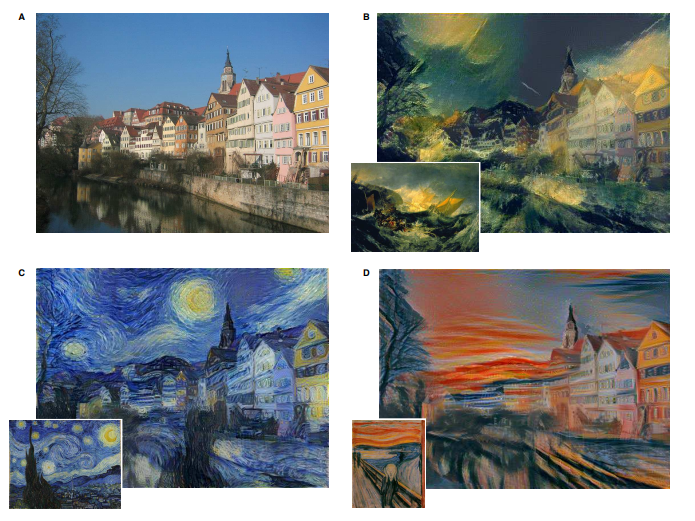

# Definition
style transfer is a set of algorithms that adopt the visual appearance of images without changing its content.
Given two input images a content image and a style image our model will learn stylistic features of one image and apply them to the second one.
To preserve the content, we will define a loss function that takes in consideration the style and content of the resulting image.

## what is the style of an image?
the most important stylistic feature in image is the colors that it contains. other stylistic features could be the way things are portrayed and the shapes.

## what is the content of an image?
the feature that represents the content of an image the most is the objects in that image. but in a Convolutional layer we don't detect objects directly. we detect corners and edges.

## how can we extract the content and style of an image?
now that we know what we are looking for. how could we make a machine know what it should look for in an image?. As we already explained, every convolutional layer in our CNN works as a feature extractor. and features could be anything that distinguishes an image like the shapes and patterns that are present in that image. in 2016 researchers published A paper called style transfer using deep convolutional networks. where they used a CNN model called VGG19 to do style transfer. first let's talk about the VGG19 model.

## VGG19
VGG-19 is a trained Convolutional Neural Network, from Visual Geometry Group, Department of Engineering Science, University of Oxford. The number 19 stands for the number of layers with trainable weights. 16 Convolutional layers and 3 Fully Connected layers. VGG19 is a pretrained model. which means that the weights are not random but are useful for detecting the right patterns in images. VGG19 has been trained on more than a million images from the ImageNet database.
![VGG19 architecture](https://miro.medium.com/max/1200/0*5uxP_d6UTy6NlHAU)

the VGG19 model was originally made for image classification and was incredibly good at it, to classify an image the model must learn to identify shapes and colors that distinguish each class of images. as our input image is passed through our network some layers detect content features and some style features. thanks to a [previously mentioned paper](https://zpascal.net/cvpr2016/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) published on style transfer we know the layers that are responsible for the style (basic shapes, colors etc) and the ones responsible for the content (image-specific features)
##### content layer: layer conv4_2
##### style layers: conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1.












## Downloading our VGG19 model

In [0]:
import torch
import torchvision
import torch.optim as optim
from torchvision import transforms, models
# the vgg model is split  into two part the features and classifiers
# the classifiers are the three last linear layers
# the features are the conv and maxpool layers
# in our case we will only need the features
vgg = models.vgg19(pretrained=True).features
# we will not be changing the weights of the vgg model so we stop pytorch from automaticly calculating the gradiant for better performance.
for param in vgg.parameters():
    param.requires_grad_(False)

## The loss function
like all models in ML we need a loss function that tells us how good we are doing and gives us an indication about where to go. in our case the loss function is simple. we pass the new image through our pretrained vgg19 model, we look to the layers that we mentioned earlier to know how far is the content and style from the original image. we only need to pass the original content image once. and every time we change the picture we pass it again to know if the changes we did are good or bad.
this is indicated by the sum of two loss functions.

since we know that we'll be extracting features from the vgg19 model let's first build a method that does that.


**get_features** will pass the image through VGG19 and return a map of the layers that we previously mentioned.



## TO-DO
define the **get_features** method print the 

In [0]:
def get_features(image, model, layers=None):
# use print(vgg) to see the layers of the model
# creat a map of the layers so we could use those names as an index
    if layers is None:
        layers = {'0': 'conv1_1',
                  }

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

now that we have the features of the new image let's calculate the error. it's going to be the sum of:
### content_loss 
it's the mean squared distance between the features of conv4_2

### style_loss
style loss is a little more complicated. to calculate the loss function, we will have to calculate the gram matrix for each feature layer. to understand why we do this let's first talk about the the **gram matrix**.

the gram matrix is the product of a matrix and its transpose. we will do this for every layer of the style layers. we actually don't calculate the gram matrix for the features directly. we must build a new matrix where each line in the new matrix represents the values of one filter. the gram matrix is not the only way we can detect correlation between features.

the style loss function is the mean square of the distance between the gram matrices for the new image and the original style image.




In [0]:
def gram_matrix(tensor):
    
    # get the shape of the input tensor and ignore the first parameter(the batch size)

    # we need to reshape our tensors so that each line represtents the result of one filtre.

    # calculate the gram matrix

    return gram

## Adding some methods to get images and show them

In [0]:
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import numpy as np

def load_image(img_path, max_size=800, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image


# using the method we defined we get the content image
content = load_image('https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg')
# again we get the style image. this time we reshape the image so that the two images are compatible.
style = load_image('https://www.vangoghstudio.com//Files/6/102000/102147/ProductPhotos/Source/307257209.jpg', shape=content.shape[-2:])



def im_convert(tensor):
    """ 
    when loading the images we changed (normalized) the values and changed the type to a tensor.
    we need to denormelize the values so we could show the images.
     """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image



# Now for the main code

In [0]:
# as we said we will need to get the features of the original content image and the style image only once.
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# to calculate the style error we need the gram matreces for the original style image
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change by setting requires_grad to true.
# since we want the content to be more apparent we start with a clone of the content image 
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)
# creat a map to the layers that give us style representation
# this map will contain weights for each layer
# note that we prioretize the layers at the beginning because they have more information about the style
style_weights = {    }

# we don't want the new image to take in considiration the style and content with the same weight
# so we set two weights
content_weight = 1  # alpha
style_weight = 1e8  # beta 
# we want to see how our image is changing every "show_every" steps (here a 1000)
show_every = 1000

# iteration hyperparameters
# defining our optimizer so we could change the target image using gradiant descent
# here we are using the adam optimizer. you could try others and see how it affects your model
optimizer = optim.Adam([target], lr=0.003)
steps = 20000  # decide how many iterations to update your image over.

for step in range(1, steps + 1):

    # get the features from your target image
    target_features = get_features(target, vgg)

    # the content loss from the layer conv4_2
    # use torch.mean()

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        
        # get the "style" style representation


        # the style loss for one layer, weighted appropriately
  

        # add to the style loss
        style_loss =style_loss+ layer_style_loss / (d * h * w)

    # calculate the *total* loss
    

    # update your target image using gradiant descent
    

    # display intermediate images and print the loss
    if step % show_every == 0:
        print('Total loss: ', total_loss.item())
        # display the images
        



References:

*   [the 2016 paper on style transfer](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
*   [Udacity's introduction to deep learning with pytorch](https://www.udacity.com/course/deep-learning-pytorch--ud188)


